In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
import shutil
import os 
import math

In [25]:
parent_dir = '/content/drive/My Drive/DL/Data_for_DL'
#Printing Category list to see if completely mounted and working
os.chdir(parent_dir)
category_list = list(filter(lambda x: os.path.isdir(x), os.listdir()))
for category in category_list:
  print(category)

rocket
drone
passenger-plane
helicopter
fighter-jet
missile


In [ ]:
#Create training and testing directories
data_set_dirs= ['train','test']
for dsdirs in data_set_dirs:
  path = '/content/drive/My Drive/DL' + '/'+ dsdirs
  os.mkdir( path,755 )

In [ ]:
train_prop = 0.7
test_prop = (1-train_prop)

#Defining function to split data of each category into trainning and testing set
def create_dataset():
  for ii,cat in enumerate(category_list):    
    src_path = parent_dir + '/' + cat
    dest_dir1 = '/content/drive/My Drive/DL'+'/train/'+str(ii)
    dest_dir2 = '/content/drive/My Drive/DL'+'/test/'+str(ii)
    
    dest_dirs_list = [dest_dir1,dest_dir2]
    for dirs in dest_dirs_list:
      os.mkdir(dirs,755 )
    
    #get files' names list from respective directories
    os.chdir(src_path)
    files = [f for f in os.listdir() if os.path.isfile(f)]
    
    #get training and training files count
    train_count = math.ceil(train_prop*len(files))
    test_count = int((len(files)-train_count))
     
    
    #get files to segragate for train and test data set
    train_data_list = files[0: train_count]
    test_data_list = files[train_count+1:]       
  
    for train_data in train_data_list:
      train_path = src_path + '/' + train_data
      shutil.copy(train_path,dest_dir1)
    
    for test_data in test_data_list:
      test_path = src_path + '/' + test_data
      shutil.copy(test_path,dest_dir2)
#Calling Function      
create_dataset()

In [ ]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout
from keras.optimizers import RMSprop
import numpy as np
from keras.utils.np_utils import to_categorical
from keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt 

In [ ]:
#Image augmentation on Training Data 
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1/255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    )
test_datagen = ImageDataGenerator(
    rescale=1./255,
)

In [28]:
train_generator = train_datagen.flow_from_directory(
    '/content/drive/My Drive/DL/train',
    target_size=(224,224),
    batch_size=100,
    class_mode=None,
    shuffle = False
)
test_generator = test_datagen.flow_from_directory(
    '/content/drive/My Drive/DL/test',
    target_size=(224,224),
    batch_size=100,
    class_mode=None,
    shuffle= False
)


Found 5908 images belonging to 6 classes.
Found 2528 images belonging to 6 classes.


In [ ]:
#Training Images loaded to VGG16 Model
batch_size= 100
vgg16 = keras.applications.VGG16(include_top=False, weights='imagenet')
size= int(math.ceil(len(train_generator.filenames)  / batch_size)) 
 
vgg16_train = vgg16.predict_generator(train_data, size) 
np.save('/content/drive/My Drive/DL/vgg16_train.npy', vgg16_train)

In [ ]:
#Testing Images loaded to VGG16 Model
size2= int(math.ceil(len(test_generator.filenames)  / batch_size)) 
 
vgg16_test = vgg16.predict_generator(train_data, size2) 
np.save('/content/drive/My Drive/DL/vgg16_test.npy', vgg16_test)

In [34]:
#Loading the VGG16 Featured data
 
# load the features saved earlier 
train_data = np.load('/content/drive/My Drive/DL/bottleneck_features_train.npy') 
test_data = np.load('/content/drive/My Drive/DL/vgg16_test.npy') 

generator1 = ImageDataGenerator(rescale = 1./255).flow_from_directory( 
   '/content/drive/My Drive/DL/train', 
   target_size=(224,224), 
   batch_size=100, 
   class_mode='categorical', 
   shuffle=False,) 

generator2 = ImageDataGenerator(rescale = 1./255).flow_from_directory( 
   '/content/drive/My Drive/DL/test', 
   target_size=(224,224), 
   batch_size=100, 
   class_mode='categorical', 
   shuffle=False,) 
# get the class labels for the training data and test data in the original order 
train_labels = generator1.classes 
test_labels = generator2.classes

# convert the training labels and test labels to categorical vectors 
train_labels = to_categorical(train_labels, num_classes=6)
test_labels = to_categorical(test_labels, num_classes=6)

Found 5908 images belonging to 6 classes.
Found 2528 images belonging to 6 classes.


In [35]:
#Adding new layers, softmax and fitting and training
model = Sequential() 
model.add(Flatten(input_shape=train_data.shape[1:])) 
model.add(Dense(100, activation=keras.layers.LeakyReLU(alpha=0.3))) 
model.add(Dropout(0.5)) 
model.add(Dense(50, activation=keras.layers.LeakyReLU(alpha=0.3))) 
model.add(Dropout(0.3)) 
model.add(Dense(6, activation='softmax'))
model.compile(loss='categorical_crossentropy',
   optimizer=keras.optimizers.RMSprop(),
   metrics=['acc'])

history = model.fit(train_data, train_labels, 
   epochs=20,
   batch_size=100, 
   validation_data=(test_data, test_labels),
       callbacks=[
        
        ReduceLROnPlateau(patience=3)])
model.save_weights('/content/drive/My Drive/DL/vgg_saved_weights.h5')
(eval_loss, eval_accuracy) = model.evaluate( 
    test_data, test_labels, batch_size=100,     verbose=1)
print("[INFO]Test data accuracy: {:.2f}".format(eval_accuracy * 100)) 
print("[INFO]Test data Loss: {}".format(eval_loss)) 

Epoch 1/20
60/60 [==============================] - 3s 54ms/step - loss: 3.2594 - acc: 0.2866 - val_loss: 3.4077 - val_acc: 0.2421
Epoch 2/20
60/60 [==============================] - 3s 50ms/step - loss: 1.9212 - acc: 0.4018 - val_loss: 1.8046 - val_acc: 0.4953
Epoch 3/20
60/60 [==============================] - 3s 56ms/step - loss: 1.6685 - acc: 0.4609 - val_loss: 1.2528 - val_acc: 0.5787
Epoch 4/20
60/60 [==============================] - 4s 65ms/step - loss: 1.5101 - acc: 0.4870 - val_loss: 2.7570 - val_acc: 0.3430
Epoch 5/20
60/60 [==============================] - 3s 52ms/step - loss: 1.4222 - acc: 0.5295 - val_loss: 1.7774 - val_acc: 0.4486
Epoch 6/20
60/60 [==============================] - 3s 51ms/step - loss: 1.3164 - acc: 0.5476 - val_loss: 1.4409 - val_acc: 0.5210
Epoch 7/20
60/60 [==============================] - 3s 51ms/step - loss: 0.9624 - acc: 0.6427 - val_loss: 1.0351 - val_acc: 0.6487
Epoch 8/20
60/60 [==============================] - 3s 51ms/step - loss: 0.7982 - a

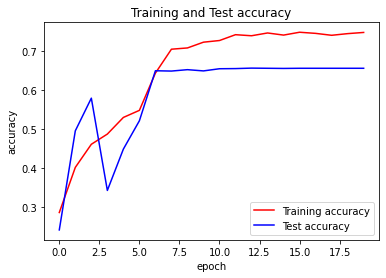

In [36]:
#Graphing our training and validation
acc = history.history['acc']
test_acc = history.history['val_acc']
loss = history.history['loss']
test_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, test_acc, 'b', label='Test accuracy')
plt.title('Training and Test accuracy')
plt.ylabel('accuracy') 
plt.xlabel('epoch')
plt.legend()
plt.show()

In [37]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import itertools
categorical_test_labels = pd.DataFrame(test_labels).idxmax(axis=1)
predictions = np.round(model.predict(test_data,0))
categorical_predictions = pd.DataFrame(predictions).idxmax(axis=1)
confusion_matrix= confusion_matrix(categorical_test_labels, categorical_predictions)

#To get better visual of the confusion matrix:
def plot_confusion_matrix(cm, classes,
   normalize=False,
   title='Confusion matrix',
   cmap=plt.cm.Blues):
 
#Add Normalization Option
 
   if normalize:
     cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
     print("Normalized confusion matrix")
   else:
     print('Confusion matrix, without normalization')
 
# print(cm)
 
   plt.imshow(cm, interpolation='nearest', cmap=cmap)
   plt.title(title)
   plt.colorbar()
   tick_marks = np.arange(len(classes))
   plt.xticks(tick_marks, classes, rotation=45)
   plt.yticks(tick_marks, classes)
 
   fmt = '.2f' if normalize else 'd'
   thresh = cm.max() / 2.
   for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
 
   plt.tight_layout()
   plt.ylabel('True label')
   plt.xlabel('Predicted label') 

Normalized confusion matrix


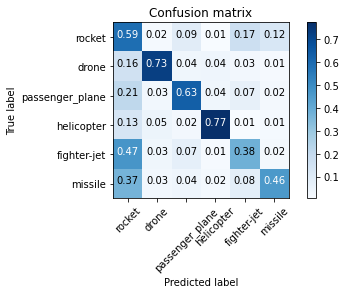

In [38]:
plot_confusion_matrix(confusion_matrix,['rocket','drone','passenger_plane','helicopter','fighter-jet','missile'],normalize= True)